In [1]:
import sys
sys.path.append('..')

In [2]:
from utils import dump_jsonl, load_jsonl

In [3]:
import pandas as pd

users = ["user1", "user2", "user3"]

def authority_to_eng(label):
    if label == 'B ให้เกียรติ':
        return "1. Respect"
    elif label == 'B ทำตัวปกติ':
        return "2. Normal"
    elif label == 'B ไม่ให้เกียรติกัน':
        return "3. Not respect"
    else:
        return None

def closeness_to_eng(label):
    if label == 'สนิทกันมาก':
        return "1. Close"
    elif label == 'สนิทกัน':
        return "1. Close"
    elif label == 'แค่คนรู้จักกัน':
        return "2. Know each other"
    elif label == 'ไม่รู้จักกัน':
        return "3. Don't know each other"
    elif label == 'ไม่ชอบหน้ากัน':
        return "4. Don't like each other"
    else:
        return None
    
    
def load_data(filename, column_name, fn=None):
    annotated = load_jsonl(filename)
    
    _df = []
    for row in annotated:
        
        if len(row["label"])==0:
            label = None
        else:
            if fn is None:
                label = row["label"][0]
            else:
                label = fn(row["label"][0])

        _df.append({
            "text": row["text"],
            "text_id": row["id"],
            "ref_idx": row["idx"],
            column_name: label,
        })
    
    return pd.DataFrame(_df)

In [4]:


def get_label_type(out_df, key):
    
    data_type = []
    labels = []

    for ridx, row in out_df.iterrows():
        if row[f"{key}_1"]==row[f"{key}_2"] and row[f"{key}_2"]==row[f"{key}_3"]:
            data_type.append("gold")
            labels.append(row[f"{key}_1"])

        elif row[f"{key}_1"]!=row[f"{key}_2"] and row[f"{key}_2"]!=row[f"{key}_3"] and row[f"{key}_1"]!=row[f"{key}_3"]:
            data_type.append("failed")
            labels.append(None)
        else:
            data_type.append("silver")
            if row[f"{key}_1"]==row[f"{key}_2"]:
                labels.append(row[f"{key}_1"])
            elif row[f"{key}_1"]==row[f"{key}_3"]:
                labels.append(row[f"{key}_1"])
            elif row[f"{key}_2"]==row[f"{key}_3"]:
                labels.append(row[f"{key}_2"])
            else:
                raise Exception("Unknow situation")

    out_df["data_type"] = data_type
    out_df[key] = labels
    
    return out_df
    
    
def get_data(key, fn):
    out_df = load_data(f"annotated/{key}/user0.jsonl", key)
    out_df = out_df[["text", "text_id", "ref_idx"]]
    
    for uidx, u in enumerate(users):
        df = load_data(f"annotated/{key}/{u}.jsonl", key, fn)
        df.columns = ['text', 'text_id', "ref_idx", f'{key}_{uidx+1}']

    #     df = df.drop_duplicates(subset=['text'])
        df = df[['text_id', f'{key}_{uidx+1}']]

        out_df = pd.merge(out_df, df, on="text_id", how="left")
        print(len(out_df))
        
        # print(df[f'{key}_{uidx+1}'].unique())
    
    out_df = get_label_type(out_df, key)
    return out_df

## Closeness

In [5]:
clos_df = get_data("closeness", closeness_to_eng)

Loaded 2639 records from annotated/closeness/user0.jsonl
Loaded 2639 records from annotated/closeness/user1.jsonl
2639
Loaded 2639 records from annotated/closeness/user2.jsonl
2639
Loaded 2639 records from annotated/closeness/user3.jsonl
2639


In [6]:
clos_df.head()

,text,text_id,ref_idx,closeness_1,closeness_2,closeness_3,data_type,closeness
0,B: ที่บ้านเป็นร้านค้าด้วยตอนเช้าแม่ก็จะซื้อกับ...,42479,628,2. Know each other,2. Know each other,2. Know each other,gold,2. Know each other
1,B: สวัสดี​ค่า\nA: จ้าา\nB: พี่ชอบฟังเพลงอะไรไห...,42480,566,2. Know each other,2. Know each other,3. Don't know each other,silver,2. Know each other
2,A: ใช่ค่ะ\nA: พังงา\nB: มีเพื่อนอยู่พังงาเหมือ...,42481,1203,2. Know each other,2. Know each other,2. Know each other,gold,2. Know each other
3,B: ทักก\nA: รับค่าา\nA: เจอกันอีกนะ\nB: จ้าาา\...,42482,807,2. Know each other,2. Know each other,3. Don't know each other,silver,2. Know each other
4,A: ϵ( 'Θ' )϶ปลาปุงปัง\nB: มังกรเป็นงูมั้ย\nA: ...,42483,393,1. Close,1. Close,2. Know each other,silver,1. Close


In [7]:
clos_df[["text", "data_type"]].groupby("data_type").count()

,text
data_type,
failed,50
gold,1132
silver,1457


In [8]:
print("Usable Records:", len(clos_df[clos_df["data_type"]!="failed"]))

Usable Records: 2589


<AxesSubplot:>

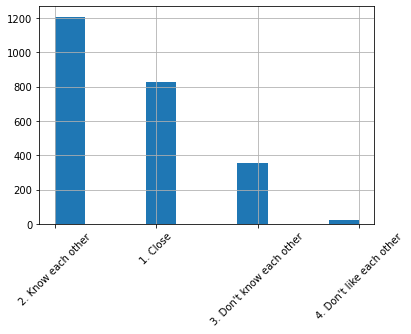

In [9]:
clos_df["closeness"].hist(xrot=45)

In [10]:
clos_df[["text", "closeness"]].groupby("closeness").count()

,text
closeness,
1. Close,830
2. Know each other,1208
3. Don't know each other,353
4. Don't like each other,25


## Authority

In [11]:
auth_df = get_data("authority", authority_to_eng)

Loaded 2639 records from annotated/authority/user0.jsonl
Loaded 2639 records from annotated/authority/user1.jsonl
2639
Loaded 2639 records from annotated/authority/user2.jsonl
2639
Loaded 2639 records from annotated/authority/user3.jsonl
2639


In [12]:
auth_df = auth_df.drop_duplicates(subset=['text'])
len(auth_df)

2637

In [13]:
auth_df[["text", "data_type"]].groupby("data_type").count()

,text
data_type,
failed,21
gold,1347
silver,1269


<AxesSubplot:>

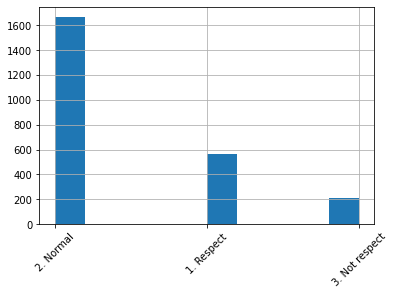

In [14]:
auth_df["authority"].hist(xrot=45)

In [15]:
auth_df[["text", "authority"]].groupby("authority").count()

,text
authority,
1. Respect,564
2. Normal,1665
3. Not respect,214


In [16]:
# auth_df

## Export

In [17]:
clos_df

,text,text_id,ref_idx,closeness_1,closeness_2,closeness_3,data_type,closeness
0,B: ที่บ้านเป็นร้านค้าด้วยตอนเช้าแม่ก็จะซื้อกับ...,42479,628,2. Know each other,2. Know each other,2. Know each other,gold,2. Know each other
1,B: สวัสดี​ค่า\nA: จ้าา\nB: พี่ชอบฟังเพลงอะไรไห...,42480,566,2. Know each other,2. Know each other,3. Don't know each other,silver,2. Know each other
2,A: ใช่ค่ะ\nA: พังงา\nB: มีเพื่อนอยู่พังงาเหมือ...,42481,1203,2. Know each other,2. Know each other,2. Know each other,gold,2. Know each other
3,B: ทักก\nA: รับค่าา\nA: เจอกันอีกนะ\nB: จ้าาา\...,42482,807,2. Know each other,2. Know each other,3. Don't know each other,silver,2. Know each other
4,A: ϵ( 'Θ' )϶ปลาปุงปัง\nB: มังกรเป็นงูมั้ย\nA: ...,42483,393,1. Close,1. Close,2. Know each other,silver,1. Close
...,...,...,...,...,...,...,...,...
2634,B: สวัสดีค่ะ\nA: 555 ดีครับ\nB: ดนตรีคือชีวิต\...,45113,773,2. Know each other,3. Don't know each other,3. Don't know each other,silver,3. Don't know each other
2635,B: ดีค่ะ\nA: ดีฮะ\nA: อารมณ์ไหนของมึง555\nB: เ...,45114,529,1. Close,1. Close,1. Close,gold,1. Close
2636,B: มึง\nA: เออ ๆ \nA: ว่า\nB: ไอตันอะ มันไปออก...,45115,544,1. Close,1. Close,1. Close,gold,1. Close
2637,B: สวัสดีค่า ชื่อเนมค่ะ\nA: สวัสดีค่า กิ๊กค่ะ\...,45116,615,2. Know each other,3. Don't know each other,3. Don't know each other,silver,3. Don't know each other


In [18]:
A = clos_df[['text', 'ref_idx', 'closeness_1', 'closeness_2', 'closeness_3', 'closeness']]
B = auth_df[['text', 'authority_1', 'authority_2', 'authority_3', 'authority']]

In [19]:
M = pd.merge(A, B, on="text")

In [20]:
annotated = []
for idx, row in M.iterrows():
    messages = row["text"].split("\n")
    row["text"] = messages
    annotated.append({ **row })

dump_jsonl("./annotated/raw_annotated.jsonl", annotated)

Wrote 2639 records to ./annotated/raw_annotated.jsonl


In [21]:
# M["closeness"].isna().sum()

#### Map with original data

In [24]:
original_data = load_jsonl("../Task1/annotated_conersations.jsonl")

Loaded 1234 records from ../Task1/annotated_conersations.jsonl


In [33]:

def match_with_original(ori, row):
    ori = original_data[row["ref_idx"]]
    ori_messages = [m["text"] for m in ori["messages"]]
    
    messages = row["text"].split("\n")
    notmatched = 0
    for m in messages:
        if m[3:] not in ori_messages:
            notmatched += 1
    notmatched -=1
    
    return notmatched==0

In [34]:
AUTHORITY_LABELS = ["1. Respect", "2. Normal", "3. Not respect"]
CLOSENESS_LABELS = ["1. Close", "2. Know each other", "3. Don't know each other", "4. Don't like each other"]

In [46]:
# Note: one conversation will be splitted and annotated in several parts

In [63]:

# get the most common label from list
def get_label_from_annotaed_sections(lst):
    return max(set(lst), key=lst.count)

nerror = {}
annotated = []
for idx, conv in enumerate(original_data):
    rows = M[M["ref_idx"]==idx]
    
    clos_labels = []
    auth_labels = []
    for _, row in rows.iterrows():
        if not match_with_original(conv, row):
            print("ERROR??")
        
        clos_labels.append(row["closeness_1"])
        clos_labels.append(row["closeness_2"])
        clos_labels.append(row["closeness_3"])
        
        auth_labels.append(row["authority_1"])
        auth_labels.append(row["authority_2"])
        auth_labels.append(row["authority_3"])
        
        # if pd.isna(row["authority_3"]):
        #     print(rows)
        #     assert(False)
            
        for col in ["closeness_1", "closeness_2", "closeness_3", "authority_1", "authority_2", "authority_3"]:
            if col+"_list" not in conv:
                conv[col+"_list"] = []
                
            conv[col+"_list"].append(row[col])
    
    clos_labels = [l for l in clos_labels if l is not None]
    auth_labels = [l for l in auth_labels if l is not None]
    
    ## I mistakenly ignore conversation where closeness label from task1 is None 
    ## So, #data is smaller that it should be
    
    if len(clos_labels)==0 or len(auth_labels)==0:
        continue
    
    conv["closeness"] = get_label_from_annotaed_sections(clos_labels)
    conv["authority"] = get_label_from_annotaed_sections(clos_labels)
    
    
    for col in ["closeness_1", "closeness_2", "closeness_3", "authority_1", "authority_2", "authority_3"]:
        if col not in nerror:
            nerror[col] = 0
            
        labels = [l for l in conv[col+"_list"] if l is not None] 
        if len(labels)==0:
            nerror[col] += 1
            conv[col] = None
        else:    
            conv[col] = get_label_from_annotaed_sections(labels)
            if conv[col] is None:
                nerror[col] += 1
                
        del conv[col+"_list"]
    
    # conv["closeness_labels"] = cnt_clos_labels
    # conv["authority_labels"] = cnt_auth_labels

    annotated.append(conv)

In [64]:
dump_jsonl("./annotated/annotated.jsonl", annotated)

Wrote 1221 records to ./annotated/annotated.jsonl


In [65]:
nerror

{'closeness_1': 2,
 'closeness_2': 0,
 'closeness_3': 1,
 'authority_1': 12,
 'authority_2': 0,
 'authority_3': 0}

In [88]:
# d = d.dropna(subset=["closeness", "authority"], how="all")

In [90]:
# d